In [77]:
import uuid
import random
from datetime import datetime, timedelta
import mysql.connector
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# retrieve password from .env
import os
from dotenv import load_dotenv

load_dotenv()

DB_PASSWORD=os.getenv("db_password")

## Utilities

In [142]:
def generate_transactions(start_date, end_date, num_clients, trans_range, amount_range):
    """
    Generates batches of simulated blockchain transactions for each client based on a normal distribution within the specified range.

    Each batch contains all transactions for a single client, with each transaction including a randomly selected recipient (excluding the sender),
    a random date within the specified range, and a random transaction amount.

    Args:
        start_date (str): The start date for transactions in 'YYYY-MM-DD' format.
        end_date (str): The end date for transactions in 'YYYY-MM-DD' format.
        num_clients (int): The number of unique blockchain addresses (clients) to generate.
        trans_range (tuple): A tuple (min, max) specifying the range for the number of transactions per client. The actual number per client follows a normal distribution.
        amount_range (tuple): A tuple (min, max) specifying the range for the transaction amounts.

    Yields:
        list of tuple: Each yielded item is a batch of transactions for a single client. Each transaction is a tuple containing (from_id, to_id, date, amount).
    """
    # Generate unique client addresses
    clients = [str(uuid.uuid4()) for _ in range(num_clients)]
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    delta = end_date - start_date
    
    for client in clients:
        # Determine the number of transactions for this client based on a normal distribution
        num_transactions = int(np.random.normal(loc=np.mean(trans_range), scale=(trans_range[1] - trans_range[0]) / 6))
        # Ensure num_transactions falls within the specified range
        num_transactions = max(min(num_transactions, trans_range[1]), trans_range[0])
        
        client_transactions = []  # Initialize the batch for this client
        for _ in range(num_transactions):
            from_id = client
            to_id = random.choice([c for c in clients if c != from_id])  # Exclude the sender from potential recipients
            date = start_date + timedelta(days=random.randint(0, delta.days))  # Random date within the range
            amount = round(random.uniform(amount_range[0], amount_range[1]), 2) # Random amount within the range
            
            # Append this transaction to the client's batch
            client_transactions.append((from_id, to_id, date.strftime('%Y-%m-%d'), amount))
        
        yield client_transactions  # Yield the batch of transactions for this client


def insert_transactions_into_db(transactions):
    '''Inserts the generated transactions into the database. The transactions are inserted in batches to improve performance.
    
    Args:
        transactions (iterable of list of tuple): An iterable of transaction batches, where each batch is a list of tuples containing (from_id, to_id, date, amount).    
    '''
    db_connection = mysql.connector.connect(
        host="localhost",
        user="root",
        password=DB_PASSWORD,
        database="blockchain_transactions"
    )
    cursor = db_connection.cursor()
    insert_query = "INSERT INTO transactions (FromId, ToId, Date, Amount) VALUES (%s, %s, %s, %s)"
    
    for batch in transactions:  # Assuming 'transactions' is now an iterable of batches
        cursor.executemany(insert_query, batch)  # Inserting a batch of transactions
    
    db_connection.commit()
    cursor.close()
    db_connection.close()


def execute_query_to_dataframe(query, query_parameters: tuple = (), host="localhost", user="root", password="", database=""):
    """
    Executes a SQL query and returns the results as a pandas DataFrame.

    Args:
        query (str): SQL query to be executed.
        query_parameters (tuple): Parameters to be used in the query.
        host (str): Database server host. Defaults to "localhost".
        user (str): Database user. Defaults to "root".
        password (str): Password for the database user.
        database (str): Database to connect to.

    Returns:
        DataFrame: A pandas DataFrame containing the results of the executed query.

    Raises:
        Exception: If any database connection or execution error occurs.
    """
    # Establish a connection to the database
    connection = mysql.connector.connect(
        host=host,
        user=user,
        password=password,
        database=database
    )
    
    try:
        # Execute the query and fetch the results
        cursor = connection.cursor()
        cursor.execute(query.format(*query_parameters))
        result = cursor.fetchall()
        columns = [column[0] for column in cursor.description]
        
        # Convert the results to a pandas DataFrame
        df = pd.DataFrame(result, columns=columns)
        return df
    
    finally:
        # Ensure the database connection is closed after execution
        cursor.close()
        connection.close()

## Data generation

In [20]:
# Generator Parameters

start_date = '2022-12-01'
end_date = '2023-12-31'
num_clients = 10000
trans_range = (0, 20)
amount_range = (0.1, 1000)

In [21]:
# Generate transactions
transactions = generate_transactions(start_date, end_date, num_clients, trans_range, amount_range=amount_range)

# Insert transactions into the database
insert_transactions_into_db(transactions)

In [28]:
# test the database

query = "SELECT * FROM transactions LIMIT 30"

# Execute the query and convert the results to a DataFrame

execute_query_to_dataframe(query, password=DB_PASSWORD, database="blockchain_transactions")

,id,FromId,ToId,Date,Amount
0,1,5597ccd7-319a-4e8a-974d-17c4921a65a7,51578eec-dbd9-48ae-a524-bdc91a90d310,2022-12-18,402.55
1,2,5597ccd7-319a-4e8a-974d-17c4921a65a7,0618f1a1-c1e2-4ef0-913f-4411bec1b58b,2023-11-30,256.09
2,3,5597ccd7-319a-4e8a-974d-17c4921a65a7,1608bea5-4b84-4cd3-900e-195cedb9bd8e,2023-07-02,354.28
3,4,5597ccd7-319a-4e8a-974d-17c4921a65a7,bb62b9be-5ed2-462d-9d26-3f5915b16717,2023-04-08,288.00
4,5,5597ccd7-319a-4e8a-974d-17c4921a65a7,5e473cac-c580-46b2-8687-f5bcdc07b614,2023-02-15,430.70
5,6,5597ccd7-319a-4e8a-974d-17c4921a65a7,4720c7a4-f15f-40d7-8e54-4e7e868d5c93,2022-12-06,627.19
6,7,5597ccd7-319a-4e8a-974d-17c4921a65a7,2ae72741-4d29-4ddf-9752-d2019b7b9225,2023-01-19,890.14
7,8,5597ccd7-319a-4e8a-974d-17c4921a65a7,a9ed824d-7298-4556-b38a-fd1e7e708760,2023-12-04,606.62
8,9,5597ccd7-319a-4e8a-974d-17c4921a65a7,a753ae54-0fbd-4925-b8ed-e8d8db39255a,2023-03-17,24.92
9,10,5597ccd7-319a-4e8a-974d-17c4921a65a7,d7814076-922e-4930-bf03-55b91c9ce0dc,2023-07-17,52.92


## SQL Query - Client's retention data

In [388]:
# Query Parameters

## Cohort Period Definition - should cohorts be defined based on month/days/weeks of joining? - default: month
cohort_period = 'Month' # 'Month' | 'Week' | 'Day'

## Cohorts beginning date - the date from which to start counting the cohorts - in the format of day (YYYY-MM-DD)
cohort_behinning_date = '2022-12-31'

## Cohorts ending date - the date at which to stop counting the cohorts - in the format of day (YYYY-MM-DD)
cohort_ending_date = '2023-12-31'

## Address of the client to analyze
client_address = 'bfebb72f-a923-4a06-9ce1-6dd74828209f'


if cohort_period == 'Week':
    date_format = '%Y-%U',
elif cohort_period == 'Day':
    date_format = '%Y-%m-%d',
else:
    date_format = '%Y-%m',


query = '''
WITH ClientCohort AS (
    SELECT 
        Address,
        MIN(DATE_FORMAT(Date, '{}')) AS Cohort
    FROM (
        SELECT FromId AS Address, Date
        FROM transactions
        UNION ALL
        SELECT ToId AS Address, Date
        FROM transactions
    ) AS AllTransactions
    GROUP BY Address
    
), CohortSizes AS (
    SELECT 
        Cohort,
        COUNT(*) AS CohortSize
    FROM ClientCohort
    GROUP BY Cohort
), LastAppearance AS (
    SELECT 
        Address,
        MAX(Date) AS DateDropped
    FROM (
        SELECT FromId AS Address, Date
        FROM transactions
        UNION ALL
        SELECT ToId AS Address, Date
        FROM transactions
    ) AS AllTransactions
    GROUP BY Address
), CumulativeDrops AS (
    SELECT 
        CC.Address,
        CC.Cohort,
        LA.DateDropped,
        COUNT(*) OVER (PARTITION BY CC.Cohort ORDER BY LA.DateDropped) AS CumulativeDropped
    FROM LastAppearance LA
    JOIN ClientCohort CC ON LA.Address = CC.Address
), DroppedOnDate AS (
    SELECT 
        Cohort,
        DateDropped,
        COUNT(*) AS NumberDropped
    FROM CumulativeDrops
    GROUP BY Cohort, DateDropped
)
SELECT 
    CC.Address,
    CC.Cohort,
    CS.CohortSize,
    LA.DateDropped,
    DOD.NumberDropped,
    CD.CumulativeDropped
FROM 
    ClientCohort CC
    JOIN CohortSizes CS ON CC.Cohort = CS.Cohort
    JOIN LastAppearance LA ON CC.Address = LA.Address
    JOIN CumulativeDrops CD ON CC.Address = CD.Address AND CC.Cohort = CD.Cohort
    JOIN DroppedOnDate DOD ON CC.Cohort = DOD.Cohort AND LA.DateDropped = DOD.DateDropped
WHERE 
    CC.Cohort >= DATE_FORMAT('{}','%Y-%m-%d') AND CC.Cohort <= DATE_FORMAT('{}', '%Y-%m-%d')

ORDER BY 
    CC.Cohort, LA.DateDropped;
'''

# Execute the query and convert the results to a DataFrame
params = (date_format[0], cohort_behinning_date, cohort_ending_date)

df_client_info = execute_query_to_dataframe(query, params, password=DB_PASSWORD, database="blockchain_transactions")

In [389]:
# Display the DataFrame

df_client_info

,Address,Cohort,CohortSize,DateDropped,NumberDropped,CumulativeDropped
0,649732ab-03b4-4187-a033-cc35d4e03cf0,2023-01,1731,2023-06-04,1,1
1,59eb299c-6bd0-475a-81fc-9dea5aeaaa58,2023-01,1731,2023-07-16,1,2
2,ae122000-b5aa-4ef7-b5bd-bc8e64d6429d,2023-01,1731,2023-07-17,1,3
3,8dbf5cc5-f8bd-4a8a-a432-8b0865a3a95d,2023-01,1731,2023-07-26,1,4
4,a8e8d63d-51cf-4862-920d-70545623b8d2,2023-01,1731,2023-08-22,1,5
...,...,...,...,...,...,...
2248,d7c209ad-532f-4c0a-b4a5-8a9999283e0d,2023-05,5,2023-11-07,1,2
2249,cd8d0387-b15c-4172-843b-a16c76c03d88,2023-05,5,2023-11-23,1,3
2250,626c8343-2d9d-43cf-8819-f3665bffb4d2,2023-05,5,2023-12-03,1,4
2251,03c48942-330a-4083-9ea2-a0dc02ff07be,2023-05,5,2023-12-31,1,5


In [ ]:
df_client_info['CohortSizeActual'] = df_client_info['CohortSize'] - df_client_info['CumulativeDropped']

df_client_info['DateDropped'] = pd.to_datetime(df_client_info['DateDropped'])

df_client_info['MonthDropped'] = df_client_info['DateDropped'].dt.strftime('%Y-%m')

In [386]:
# pivot table

df_client_info.groupby(['Cohort', 'MonthDropped']).Address.count().unstack()

MonthDropped,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
Cohort,,,,,,,
2023-01,1.0,3.0,2.0,13.0,72.0,328.0,1312.0
2023-02,NaN,NaN,1.0,7.0,17.0,57.0,303.0
2023-03,NaN,NaN,NaN,1.0,4.0,19.0,89.0
2023-04,NaN,NaN,NaN,NaN,NaN,5.0,13.0
2023-05,NaN,NaN,NaN,NaN,1.0,2.0,2.0
2023-06,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
# view for a single client

df_client_info[df_client_info['Address'] == client_address]

,Address,Cohort,CohortSize,DateDropped,NumberDropped,CumulativeDropped,CohortSizeActual,MonthDropped
11,bfebb72f-a923-4a06-9ce1-6dd74828209f,2023-01,1731,2023-09-20,1,12,1719,2023-09


## SQL Query - Cohorts: Monthly Retention

### Query for retention of all users

In [39]:
query = '''
SELECT 
    YearMonth,
    UniqueAddresses,
    IFNULL((UniqueAddresses / LAG(UniqueAddresses) OVER (ORDER BY YearMonth)), 1) AS PercentageOfLastMonth
FROM (
    SELECT 
        DATE_FORMAT(Date, '%Y-%m') AS YearMonth,
        COUNT(DISTINCT Address) AS UniqueAddresses
    FROM (
        SELECT FromId AS Address, Date
        FROM transactions
        UNION
        SELECT ToId AS Address, Date
        FROM transactions
    ) AS combined_addresses
    GROUP BY YearMonth
) AS monthly_unique_addresses
ORDER BY YearMonth;
'''

# Execute the query and convert the results to a DataFrame
execute_query_to_dataframe(query, password=DB_PASSWORD, database="blockchain_transactions")

,YearMonth,UniqueAddresses,PercentageOfLastMonth
0,2022-12,7747,1.0000
1,2023-01,7727,0.9974
2,2023-02,7345,0.9506
3,2023-03,7724,1.0516
4,2023-04,7598,0.9837
5,2023-05,7765,1.0220
6,2023-06,7551,0.9724
7,2023-07,7672,1.0160
8,2023-08,7668,0.9995
9,2023-09,7614,0.9930


In [399]:
# parameters:

## retention period - should the retention be calculated based on month/week/day? - default: month
retention_period = 'Month' # 'Month' | 'Week' | 'Day'

if retention_period == 'Week':
    date_format = '%Y-%U',
elif retention_period == 'Day':
    date_format = '%Y-%m-%d',
else:
    date_format = '%Y-%m',


query = '''
WITH UserCohorts AS (
    SELECT 
        Address,
        MIN(DATE_FORMAT(Date, '%Y-%m')) AS CohortMonth
    FROM (
        SELECT FromId AS Address, Date
        FROM transactions
        UNION ALL
        SELECT ToId AS Address, Date
        FROM transactions
    ) AS AllTransactions
    GROUP BY Address
), Activity AS (
    SELECT 
        UC.CohortMonth,
        DATE_FORMAT(T.Date, '{}') AS ActivityTime,
        COUNT(DISTINCT T.Address) AS ActiveUsers
    FROM (
        SELECT FromId AS Address, Date
        FROM transactions
        UNION ALL
        SELECT ToId AS Address, Date
        FROM transactions
    ) AS T
    JOIN UserCohorts UC ON T.Address = UC.Address
    GROUP BY UC.CohortMonth, ActivityTime
), ActivityWithPreviousPeriod AS (
    SELECT 
        CohortMonth,
        ActivityTime,
        ActiveUsers,
        LAG(ActiveUsers) OVER (PARTITION BY CohortMonth ORDER BY ActivityTime) AS PreviousPeriodUsers
    FROM Activity
)
SELECT 
    CohortMonth,
    ActivityTime,
    ActiveUsers,
    IFNULL((ActiveUsers / PreviousPeriodUsers) * 100, 100) AS PercentageOfLastPeriod
FROM ActivityWithPreviousPeriod
ORDER BY CohortMonth, ActivityTime;
'''

params = (date_format[0],)
# Execute the query and convert the results to a DataFrame
df_cohorts = execute_query_to_dataframe(query, params, password=DB_PASSWORD, database="blockchain_transactions")

In [400]:
df_cohorts.head()

,CohortMonth,ActivityTime,ActiveUsers,PercentageOfLastPeriod
0,2022-12,2022-12,7747,100.0000
1,2022-12,2023-01,5996,77.3977
2,2022-12,2023-02,5693,94.9466
3,2022-12,2023-03,5987,105.1642
4,2022-12,2023-04,5908,98.6805


In [401]:
df_cohorts['ActivityTime']

0     2022-12
1     2023-01
2     2023-02
3     2023-03
4     2023-04
       ...   
64    2023-07
65    2023-09
66    2023-10
67    2023-11
68    2023-12
Name: ActivityTime, Length: 69, dtype: object

In [402]:
if retention_period == 'Week':
    #df_cohorts['ActivityTime'] = pd.to_datetime(df_cohorts['ActivityTime'], format='%Y-%U')
    df_cohorts['ActivityTime'] = df_cohorts['ActivityTime'].astype(str)
    # add '-1' to the end of the string in every row
    df_cohorts['ActivityTime'] = df_cohorts['ActivityTime'].apply(lambda x: str(x) + '-1')
    df_cohorts['ActivityTime'] = pd.to_datetime(df_cohorts['ActivityTime'], format='%Y-%W-%w')
    
    df_cohorts['ActivityMonth'] = pd.to_datetime(df_cohorts['ActivityTime'], format='%Y-%m')

else:
    df_cohorts['ActivityMonth'] = pd.to_datetime(df_cohorts['ActivityTime'], format='%Y-%m')

In [403]:
df_cohorts

,CohortMonth,ActivityTime,ActiveUsers,PercentageOfLastPeriod,ActivityMonth
0,2022-12,2022-12,7747,100.0000,2022-12-01
1,2022-12,2023-01,5996,77.3977,2023-01-01
2,2022-12,2023-02,5693,94.9466,2023-02-01
3,2022-12,2023-03,5987,105.1642,2023-03-01
4,2022-12,2023-04,5908,98.6805,2023-04-01
...,...,...,...,...,...
64,2023-06,2023-07,1,100.0000,2023-07-01
65,2023-06,2023-09,1,100.0000,2023-09-01
66,2023-06,2023-10,1,100.0000,2023-10-01
67,2023-06,2023-11,1,100.0000,2023-11-01


In [404]:
df_user_counts = df_cohorts[df_cohorts['CohortMonth'] == df_cohorts['ActivityMonth']].copy()

In [405]:
df_cohorts_pivot = df_cohorts.pivot_table(index='CohortMonth', columns='ActivityTime', values='PercentageOfLastPeriod', aggfunc='first').reset_index()

# add the initial number of users to the pivot table

df_cohorts_pivot = df_cohorts_pivot.merge(
    df_user_counts[['CohortMonth', 'ActiveUsers']].rename(columns={'ActiveUsers':'InitialUserCount'}), on='CohortMonth', suffixes=('', '_initial'))


# reorder the columns so that InitialUserCount is the second column
df_cohorts_pivot = df_cohorts_pivot[['CohortMonth', 'InitialUserCount'] + [col for col in df_cohorts_pivot.columns if col not in ['CohortMonth', 'InitialUserCount']]].rename(columns={'CohortMonth':'Cohort'})
 

In [406]:
df_cohorts_pivot

,Cohort,InitialUserCount,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
0,2022-12,7747,100.0000,77.3977,94.9466,105.1642,98.6805,102.2004,97.5489,101.3413,99.4136,99.9326,101.2142,99.3835,101.1400
1,2023-01,1731,NaN,100.0000,73.1947,105.0513,97.5207,102.5424,96.3937,101.9486,101.3761,97.6621,103.9382,100.0000,97.4740
2,2023-02,385,NaN,NaN,100.0000,76.1039,98.9761,99.6552,95.1557,107.2727,104.7458,91.2621,101.4184,100.0000,105.9441
3,2023-03,113,NaN,NaN,NaN,100.0000,74.3363,104.7619,97.7273,98.8372,96.4706,104.8780,98.8372,98.8235,105.9524
4,2023-04,18,NaN,NaN,NaN,NaN,100.0000,77.7778,100.0000,78.5714,127.2727,114.2857,93.7500,100.0000,86.6667
5,2023-05,5,NaN,NaN,NaN,NaN,NaN,100.0000,40.0000,150.0000,100.0000,133.3333,75.0000,100.0000,66.6667
6,2023-06,1,NaN,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,NaN,100.0000,100.0000,100.0000,100.0000


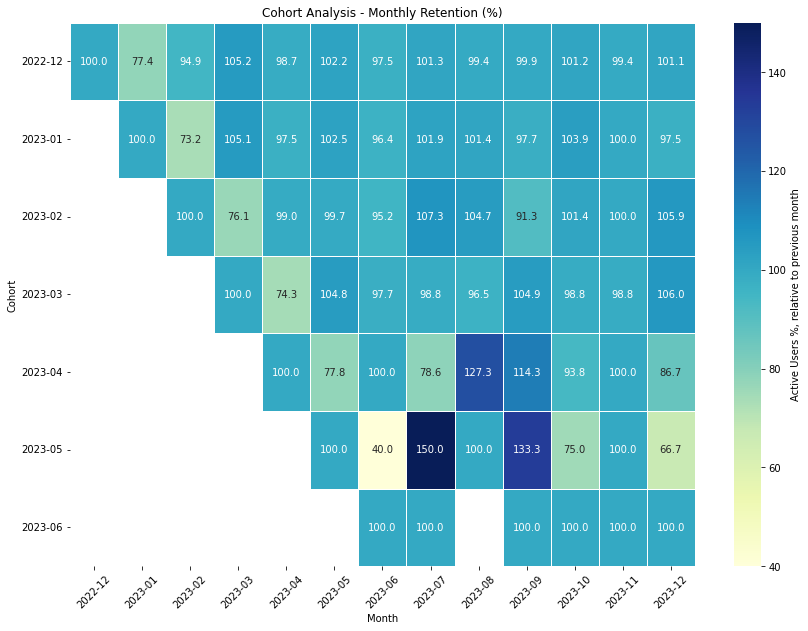

In [407]:
# Drop the 'InitialUserCount' column and set 'Cohort' as the index, then transpose
df_for_heatmap = df_cohorts_pivot.drop('InitialUserCount', axis=1).set_index('Cohort')

# Convert the DataFrame to float type to ensure all data is numeric
df_for_heatmap = df_for_heatmap.apply(pd.to_numeric, errors='coerce')

# Plotting the heatmap
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
sns.heatmap(df_for_heatmap, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Active Users %, relative to previous month'})
plt.title('Cohort Analysis - Monthly Retention (%)')
plt.xlabel('Month')
plt.ylabel('Cohort')
plt.yticks(rotation=0)  # Ensure the y-axis labels are horizontal
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()